# Multivariate LSTM Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('covid_clean_imputted.csv')

In [3]:
# shoow all columns
pd.set_option('display.max_columns', None)

In [4]:
# replace the row number with the date
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [5]:
#  sort the index by date in ascending order and then by country in descending order 
df = df.sort_index(ascending=True, axis=0)

# df = df.sort_index(ascending=True, axis=0)

In [6]:
# sort again by state
# df = df.sort_values(by=['state'])

In [7]:
df.head(5)

state  critical_staffing_shortage_today_yes  \
date                                                     
2020-01-01    TX                                   0.0   
2020-01-01    HI                                   0.0   
2020-01-01    LA                                   0.0   
2020-01-01    NC                                   0.0   
2020-01-01    MN                                   0.0   

            critical_staffing_shortage_today_no  \
date                                              
2020-01-01                                  0.0   
2020-01-01                                  0.0   
2020-01-01                                  0.0   
2020-01-01                                  0.0   
2020-01-01                                  0.0   

            critical_staffing_shortage_today_not_reported  \
date                                                        
2020-01-01                                            3.0   
2020-01-01                                            1.0   
2020-01-01                                            1.0   
2020-01-01                                            1.0   
2020-01-01                                            1.0   

            critical_staffing_shortage_anticipated_within_week_yes  \
date                                                                 
2020-01-01                                                0.0        
2020-01-01                                                0.0        
2020-01-01                                                0.0        
2020-01-01                                                0.0        
2020-01-01                                                0.0        

            critical_staffing_shortage_anticipated_within_week_no  \
date                                                                
2020-01-01                                                0.0       
2020-01-01                                                0.0       
2020-01-01                                                0.0       
2020-01-01                                                0.0       
2020-01-01                                                0.0       

            critical_staffing_shortage_anticipated_within_week_not_reported  \
date                                                                          
2020-01-01                                                3.0                 
2020-01-01                                                1.0                 
2020-01-01                                                1.0                 
2020-01-01                                                1.0                 
2020-01-01                                                1.0                 

            hospital_onset_covid  inpatient_beds  inpatient_beds_used  \
date                                                                    
2020-01-01                   0.0           790.0                 42.0   
2020-01-01                   0.0             0.0                  0.0   
2020-01-01                   0.0            41.2                 31.2   
2020-01-01                   0.0            72.0                 53.2   
2020-01-01                   0.0            46.0                 25.0   

            inpatient_beds_used_covid  \
date                                    
2020-01-01                        0.0   
2020-01-01                        0.0   
2020-01-01                        0.0   
2020-01-01                        0.0   
2020-01-01                        0.0   

            previous_day_admission_adult_covid_confirmed  \
date                                                       
2020-01-01                                           3.6   
2020-01-01                                           0.0   
2020-01-01                                           0.0   
2020-01-01                                           0.0   
2020-01-01                                           0.0   

            previous_day_admission_adult_covid_suspected  \
date    

In [8]:
df.shape

(50088, 61)

## KPSS Test

In [9]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

## Multivariate Time Series Forecasting with LSTMs in Keras

In [10]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

In [11]:
# plot the covid deaths sorted by month and grouped by state
fig = px.line(df, x=df.index, y='deaths_covid', color='state', title='Covid Deaths by State')
fig.update_layout(plot_template['layout'])
fig.show()

In [12]:
fig.update_yaxes(range = [0, 520])
fig.show()

## Create the target variable

<AxesSubplot:xlabel='date'>

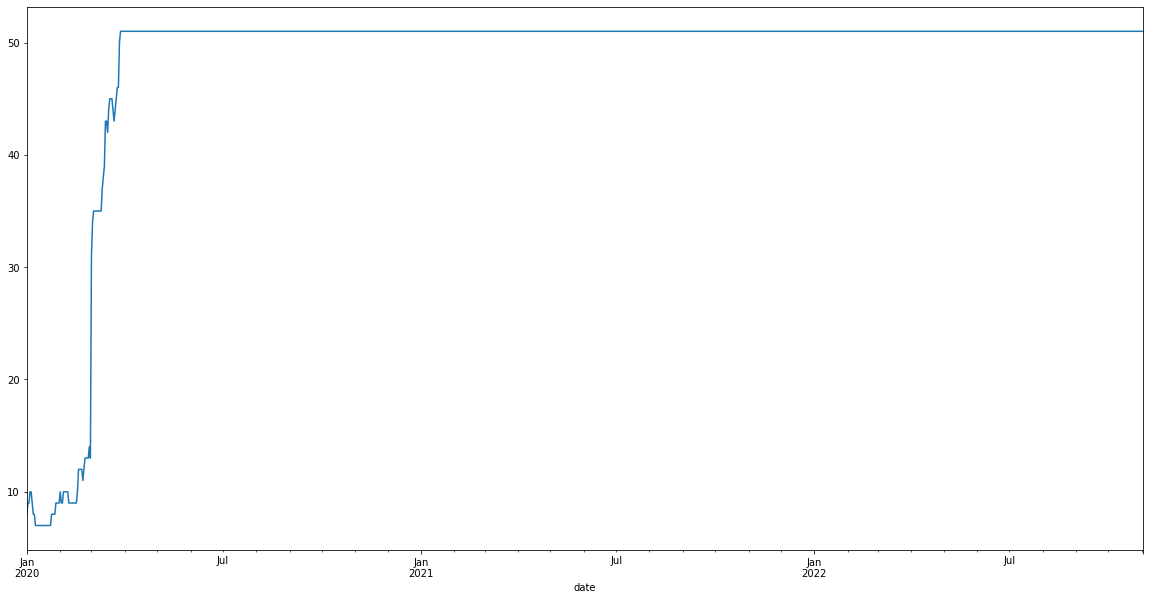

In [13]:
# how many unique states per date
# increase plot size
plt.figure(figsize=(20,10))
df.groupby('date')['state'].nunique().plot()

In [14]:
# which date are there less than 50 states
# number of unique states on 2020-03-27
df.groupby('date')['state'].nunique().loc['2020-03-27']

50

In [15]:
df.groupby('date')['state'].nunique().loc['2020-03-28']

51

In [16]:
# drop values before 2020-03-28
df = df.loc['2020-03-28':]

In [17]:
# group df by index 
df_aggregate = df.groupby('date').sum()
# df_aggregate['deaths_covid']

In [18]:
# create a new column with average deaths per day in all states
# df['deaths_avg'] = df.groupby('date')['deaths_covid'].transform('mean')

In [19]:
# df.groupby('date')['deaths_covid']

In [20]:
# create a subset of the data for the state of California
df_ca = df[df['state'] == 'CA']
# df = df_ca

In [21]:
df_aggregate.shape

(950, 60)

In [22]:
df_ca.shape

(950, 61)

In [23]:
df = df_aggregate

In [24]:
#  drop state column
# df = df.drop(['state'], axis=1)

In [25]:
target_sensor = "deaths_covid" # maybe specify a state ?
features = list(df.columns.difference([target_sensor]))

In [26]:
forecast_lead = 15
target = f"{target_sensor}_lead{forecast_lead}"

In [27]:
df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

## Create a hold-out test set and preprocess the data

In [28]:
# give the date index at 70% of the data
train_size = int(len(df) * 0.7)

In [29]:
# view row at index train_size
df.iloc[train_size]

critical_staffing_shortage_today_yes                       986.0
critical_staffing_shortage_today_no                       3380.0
critical_staffing_shortage_today_not_reported             1195.0
critical_staffing_shortage_anticipated_within_week_yes    1336.0
critical_staffing_shortage_anticipated_within_week_no     3184.0
                                                           ...  
all_pediatric_inpatient_bed_occupied                      4845.6
all_pediatric_inpatient_beds                              7168.8
staffed_pediatric_icu_bed_occupancy                       1171.2
total_staffed_pediatric_icu_beds                          1749.6
deaths_covid_lead15                                       1236.0
Name: 2022-01-11 00:00:00, Length: 61, dtype: float64

In [30]:
test_start = "2022-01-01"

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.31122994652406416


## Standardize the features and target

In [31]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

## Create datasets that PyTorch DataLoader can work with

In [32]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [33]:
i = 27
sequence_length = 8

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-0.1239, -2.6455, -1.1867, -1.6703, -2.6435, -2.6115, -1.9107, -1.7586,
         -2.0986,  2.0009, -1.9647, -2.1071,  2.0042, -1.9572, -1.0119,  0.3080,
         -2.2324, -0.4206, -2.1783, -2.6278, -0.2422, -2.9511, -2.3556, -2.6400,
          0.9124, -2.6206, -0.4335, -1.0870, -0.0700, -1.1934, -1.1657, -1.1449,
         -1.1578, -0.9793, -0.8113, -0.7510, -0.9870, -1.8820, -2.4039, -2.4915,
         -2.4564, -2.2297, -2.0067, -1.8535, -1.7947, -1.6678, -0.6025, -1.2042,
         -2.2339, -2.6494, -1.1796, -1.1397, -1.8630, -1.0646, -1.0570, -1.2368,
         -0.9342, -2.7668, -1.7002],
        [-0.0729, -2.8339, -1.1706, -1.6734, -2.8394, -2.7355, -1.9204, -1.6954,
         -2.0980,  1.9870, -1.9647, -2.1065,  1.9902, -1.9572, -1.1653,  0.2515,
         -2.4068, -0.5074, -2.2925, -2.7775, -0.3072, -3.1504, -2.5094, -2.7822,
          0.8992, -2.7673, -0.5160, -1.1015, -0.0718, -1.1797, -1.1726, -1.1647,
         -1.1483, -1.0041, -0.8165, -0.7388, -1.0098, -1.9163, -2.0638, 

In [34]:
X, y = train_dataset[i + 1]
print(X)

tensor([[-0.0729, -2.8339, -1.1706, -1.6734, -2.8394, -2.7355, -1.9204, -1.6954,
         -2.0980,  1.9870, -1.9647, -2.1065,  1.9902, -1.9572, -1.1653,  0.2515,
         -2.4068, -0.5074, -2.2925, -2.7775, -0.3072, -3.1504, -2.5094, -2.7822,
          0.8992, -2.7673, -0.5160, -1.1015, -0.0718, -1.1797, -1.1726, -1.1647,
         -1.1483, -1.0041, -0.8165, -0.7388, -1.0098, -1.9163, -2.0638, -2.3537,
         -2.4421, -2.1886, -1.9665, -1.8639, -1.7738, -1.6295, -0.6940, -1.1627,
         -2.2516, -2.7809, -1.1732, -1.1447, -1.8540, -1.0435, -1.0611, -1.2254,
         -0.9417, -3.0168, -1.6401],
        [-0.0454, -2.9109, -1.2135, -1.6914, -2.9275, -2.8166, -2.0540, -1.8885,
         -2.0980,  1.9701, -1.9647, -2.1065,  1.9732, -1.9572, -1.1916,  0.2559,
         -2.4219, -0.5093, -2.3075, -2.7942, -0.3201, -3.2158, -2.5190, -2.7968,
          0.9411, -2.7900, -0.5096, -1.1343, -0.0730, -1.2094, -1.1830, -1.2000,
         -1.2012, -1.0510, -0.8853, -0.7974, -1.0352, -1.9650, -2.1377, 

In [35]:
print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])

            adult_icu_bed_covid_utilization  \
date                                          
2020-04-17                        -0.123948   
2020-04-18                        -0.072922   
2020-04-19                        -0.045368   
2020-04-20                        -0.162805   
2020-04-21                        -0.170107   
2020-04-22                        -0.043347   
2020-04-23                        -0.016870   
2020-04-24                         0.004354   

            adult_icu_bed_covid_utilization_denominator  \
date                                                      
2020-04-17                                    -2.645496   
2020-04-18                                    -2.833901   
2020-04-19                                    -2.910880   
2020-04-20                                    -2.302313   
2020-04-21                                    -2.342472   
2020-04-22                                    -2.450046   
2020-04-23                                    -2.087637  

In [36]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 8, 59])
tensor([[[-0.7195,  0.4844, -0.5017,  ..., -0.4916,  0.4826, -0.7992],
         [-0.8172,  0.5244, -0.5447,  ..., -0.3865,  0.5200, -2.2722],
         [-0.8425,  0.5351, -0.5600,  ..., -0.4391,  0.5301, -0.7481],
         ...,
         [-0.8925,  0.4658, -0.6287,  ..., -0.4541,  0.4654,  0.2711],
         [-0.8981,  0.4501, -0.6262,  ..., -0.5316,  0.4508,  0.3097],
         [-0.9391,  0.4697, -0.6363,  ..., -0.5541,  0.4682,  0.2112]],

        [[-0.7778,  0.4882, -0.4563,  ..., -0.3966,  0.4891,  0.2702],
         [-0.7526,  0.5172, -0.4334,  ..., -0.3991,  0.5167,  0.2106],
         [-0.7855,  0.5267, -0.4445,  ..., -0.3890,  0.5257,  0.2793],
         ...,
         [-0.7516,  0.4944, -0.4542,  ..., -0.4316,  0.4937,  0.2146],
         [-0.7649,  0.4973, -0.4506,  ..., -0.4291,  0.4964,  0.2942],
         [-0.6898,  0.4709, -0.4230,  ..., -0.4741,  0.4708,  0.2227]],

        [[-1.6708,  0.3686, -1.3629,  ..., -0.8791,  0.3686,  0.7076],
         [-1.6541,  0.

## Create the datasets and data loaders for real

In [37]:
torch.manual_seed(42)

batch_size = 64
sequence_length = 14

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 14, 59])
Target shape: torch.Size([64])


## The model and learning algorithm

In [38]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [39]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [40]:
epoch = 300
train_loss = []
test_loss = []

In [41]:
def train_model(data_loader, model, loss_function, optimizer, lst):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    lst.append(avg_loss)
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function,lst):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    lst.append(avg_loss)
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function,test_loss)
print()

Untrained test
--------
Test loss: 1.0533539533615113



In [42]:
for ix_epoch in range(epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer, lst=train_loss)
    test_model(test_loader, model, loss_function, lst=test_loss)
    print()

Epoch 0
---------
Train loss: 0.8000246530229395
Test loss: 1.0424756169319154

Epoch 1
---------
Train loss: 0.8069307099689137
Test loss: 1.0337159276008605

Epoch 2
---------
Train loss: 0.7835017794912512
Test loss: 1.0230197429656982

Epoch 3
---------
Train loss: 0.7625932991504669
Test loss: 1.0150208353996277

Epoch 4
---------
Train loss: 0.8698834776878357
Test loss: 1.0056352257728576

Epoch 5
---------
Train loss: 0.7112976258451288
Test loss: 0.9999492049217225

Epoch 6
---------
Train loss: 0.8478353565389459
Test loss: 0.9927356839179993

Epoch 7
---------
Train loss: 0.6906425573609092
Test loss: 0.985911238193512

Epoch 8
---------
Train loss: 0.6842938959598541
Test loss: 0.976193630695343

Epoch 9
---------
Train loss: 0.6821181882511486
Test loss: 0.9657302021980285

Epoch 10
---------
Train loss: 0.7096803513440219
Test loss: 0.9549089312553406

Epoch 11
---------
Train loss: 0.6308254491199147
Test loss: 0.9473301887512207

Epoch 12
---------
Train loss: 0.7625402

In [43]:
# plot train_loss and test_loss with epoch in plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(epoch)), y=train_loss, name="train_loss"))
fig.add_trace(go.Scatter(x=list(range(epoch)), y=test_loss, name="test_loss"))
fig.update_layout(title="Train and Test Loss", xaxis_title="Epoch", yaxis_title="Loss")
fig.show()

In [44]:
# lowest test loss
print("Lowest test loss:", min(test_loss))

Lowest test loss: 0.29915538616478443


In [45]:
# min test loss index
print("Min test loss index:", test_loss.index(min(test_loss)))

Min test loss index: 299


## Evaluation

In [46]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

            deaths_covid_lead15  Model forecast
date                                           
2020-03-28               1235.0     1083.957031
2020-03-29               1375.0     1094.823486
2020-03-30               1547.0     1101.814575
2020-03-31               1182.0     1111.714600
2020-04-01               1105.0     1122.984497
...                         ...             ...
2022-10-14                121.0      221.727600
2022-10-15                 97.0      196.294128
2022-10-16                108.0      163.823547
2022-10-17                109.0      154.062134
2022-10-18                109.0      210.730408

[936 rows x 2 columns]


In [53]:
fig = px.line(df_out, labels=dict(created_at="Date", value="Covid Deaths"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [55]:
#  plot test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test.index, y=df_test[target], name="Actual"))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test[ystar_col], name="Forecast"))
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
# location of legend is set to top right
fig.update_layout(legend=dict(x=1, y=1))
fig.show()

In [49]:
#  calculate the mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE on train set:", mape(df_train[target], df_train[ystar_col]))
print("MAPE on test set:", mape(df_test[target], df_test[ystar_col]))

MAPE on train set: 114.10113943915728
MAPE on test set: 103.05792415947306


In [50]:
# calculate the mean absolute error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

print("MAE on train set:", mae(df_train[target], df_train[ystar_col]))
print("MAE on test set:", mae(df_test[target], df_test[ystar_col]))

MAE on train set: 0.16191187935533796
MAE on test set: 0.44346268289619084


In [51]:
# calculate the mean squared error (MSE)
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

print("MSE on train set:", mse(df_train[target], df_train[ystar_col]))
print("MSE on test set:", mse(df_test[target], df_test[ystar_col]))

MSE on train set: 0.07845843720521212
MSE on test set: 0.32652948544540716


In [52]:
# calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

print("RMSE on train set:", rmse(df_train[target], df_train[ystar_col]))
print("RMSE on test set:", rmse(df_test[target], df_test[ystar_col]))

RMSE on train set: 0.28010433271410157
RMSE on test set: 0.5714275854781664
